Matt Dula

Collaborators: Cory Hilton, Anton Schlegel, Derek Bowman, Anthony Bennett

# Writing to File in Parallel with Locks

Programs that are pleasantly parallel don't have to have their processes share any information about their "state". Unfortunately, not every problem we want to solve can be pleasantly parallel.

Its common for our programs to need to write something to file. As we'll see in this workbook, multiple processes writing to the same file at the same time is a recipe for disaster. We'll learn a couple ways to handle this problem and examine their impact on our program's weak scaling.

Recall that weak scaling is useful as a measure of parallel overhead. Parallel overhead can't be avoided, but it can be minimized. Minimizing parallel overhead is crucial if we want out programs to efficiently handle more and more amounts of work.

Some examples in this workbook are modified from [High Performance Python by Gorelick & Ozsvald](https://github.com/mynameisfiber/high_performance_python_2e/tree/master/09_multiprocessing).


## Viewing Files with Jupyter Bash Commands

Jupyter gives us the capability to execute Bash (terminal) commands inside a notebook. Bash commands should be written with an `!` at the beginning of the line:

In [1]:
!ls

hello.txt  README.md  workbook_locks.ipynb


We can use the `cat` Bash command (short for "concatenate") to print the contents of small files, such as the file `hello.txt` inside this repository:

In [2]:
!cat hello.txt

Hello world!

## File Writing Conflicts

Now that we have a way of easily viewing a file's contents within our Jupyter notebook, let's look at various ways multiple processes can write information to file. 
We'll first explore the worst case scenario: multiple processes writing to the same file at the same time. 

Take the following function as an example:

In [3]:
import os

def work(max_count, filename):

    for n in range(max_count):
        
        # Check for data already present
        if os.path.isfile(filename):
            f = open(filename, "r")
            try:
                nbr = int(f.read())
            except ValueError as err:
                # The flush argument helps print messages appear correctly
                # when multiple processes are trying to print
                print("File read error, starting to count from 0; error: " + str(err),
                      flush=True)
                nbr = 0
        else:
            print("File doesn't exist, starting to count from 0.", flush=True)
            nbr = 0 

        # Update data
        next = nbr + 1

        # Write update (overwrite existing data)
        f = open(filename, "w")
        f.write(str(next) + '\n')
        f.close()


This example is very artificial, but it mimics a case where processes are sharing information back and forth by writing it to file. This function makes a process check that file for the current result (`nbr = int(f.read())`), update it (`next = nbr + 1`), and then write out its update (`f.write(str(next) + '\n')`). In theory, another process can then read in these results and perform its own update.

If everything goes correctly, the number written to file should be the sum of each processes' value for `max_count`.

---
### Exercises

1. Run the `work` function on **one** process, with `max_count = 1000` and `filename = serial.txt`. What number is in this file when the function finishes? Does it meet your expectations?

**Warning:** If you run `work` multiple times when `serial.txt` already exists, the value inside will keep going up!

In [4]:
max_count = 1000
filename = 'serial.txt'
_ = work(max_count=max_count,filename=filename)

File doesn't exist, starting to count from 0.


Yes, the number is 1000 which meets expectations.

2. Lets run this function on **two** processes using `Pool.map`. Each process should run with `filename = parallel.txt`. They should get `max_counts` of 1,000 and 2,000.

    This is our first time using `Pool.map` with a function that takes multiple arguments. We can use `functools.partial` to fix the values of arguments other than the first (i.e., we can set parameters other than `max_counts` to values of our choosing):

    `partial_func = functools.partial(work, filename="parallel.txt")`

    We can now use `partial_func` like any other function. It's one argument is `max_counts`.

**Warning:** If you run `work` multiple times when `parallel.txt` already exists, the value inside will keep going up!

In [10]:
import functools
from multiprocessing import Pool

max_counts = [1000,2000]
filename = 'parallel.txt'

with Pool(processes=2) as p:
    partial_func = functools.partial(work,filename=filename)
    _ = p.map(func=partial_func,iterable=max_counts)

File doesn't exist, starting to count from 0.File doesn't exist, starting to count from 0.

File read error, starting to count from 0; error: invalid literal for int() with base 10: ''
File read error, starting to count from 0; error: invalid literal for int() with base 10: ''
File read error, starting to count from 0; error: invalid literal for int() with base 10: ''
File read error, starting to count from 0; error: invalid literal for int() with base 10: ''
File read error, starting to count from 0; error: invalid literal for int() with base 10: ''
File read error, starting to count from 0; error: invalid literal for int() with base 10: ''
File read error, starting to count from 0; error: invalid literal for int() with base 10: ''
File read error, starting to count from 0; error: invalid literal for int() with base 10: ''
File read error, starting to count from 0; error: invalid literal for int() with base 10: ''
File read error, starting to count from 0; error: invalid literal for i

3. You probably got an awful lot off errors! Check the number stored in `parallel.txt`. What value is written there? Given what was explained at the start of this section, what number do you expect to be there?

The number stored in `parallel.txt` is 886. This doesn't make sense with what we DESIRE, but we should expect errors as both processes are attempting to access a file that doesn't exist over and over again, so it makes sense that many values would be skipped.

---
### Explanation

When both processes first start running the `work` function, they see that no file named `parallel.txt` currently exists. Therefore, each process starts trying to count from zero. You should have seen the message "File doesn't exist, starting to count from 0" printed twice, reflecting this behavior.

It's arbitrary which process will succeed in writing to file first, an issue known as a "race condition." As one process is in the middle of writing, its possible that the other process will read the partially saved results. This partial data cannot be read properly (it appears as an empty string), causing the exception. We've structured our code so that when a process can't read the file's data, it assumes it should start the count at 0. Therefore, when the processes read the file as the other as writing, they reset the counter! This is why the final count is much lower than we expect.

Race conditions such as these can introduce bugs to our code that are hard to track down, as they are not reliably reproducible. We can use "locks" to prevent multiple processes from accessing the same resource (e.g. a file or variable) at the same time, preventing the race condition from creating bugs. We'll learn some implementations for locks in the following section.


---
## Locking File Access

We can use the `fasteners` module to ensure that only one process may write to a file at a time. This library makes use of *decorators*, a feature of the Python language that allows us to easily extend the behavior of functions.

Decorators make adding the fastener behavior easy:
```python
from fasteners import interprocess_locked

@interprocess_locked('/tmp/tmp_lock') # this is the decorator
def work(max_count, filename):
    ...
```
With this decorator, a process will not execute the `work` function until is has acquired the lock. There are other ways to use the `fasteners` module that you can investigate if you wish.

We have to provide a file name in which to store the lock information. We call this file `tmp_lock` and store it in the `/tmp` directory. The name of this file has nothing to do with the filename that `work` is using.

This is a special directory on the HPCC that is faster to access than your home, research, or scratch file spaces. The home, research, and scratch spaces are referred to as *networked filesystems*; any node can access files stored here thanks to the HPCC's internal network. The directory `/tmp` is a [*local filesystem*](https://docs.icer.msu.edu/Local_File_Systems/) and is **only accessible to the node you're running on.** If you're using processes from multiple nodes, you'll need to change the location of your lock file to something like your home directory (this will never happen with OnDemand).

The advantages of writing our lock file to `/tmp` are:
1. the file gets automatically deleted when our SLURM job ends
2. the local filesystem is generally faster to access than the networked filesystems

---
### Exercises

1. Redefine the `work` function from the previous section and add the `interprocess_locked` decorator. Then, run `work` with two processes using `Pool.map` as before. This time, have `work` use `filename = parallel_locked.txt`.

In [11]:
from fasteners import interprocess_locked

@interprocess_locked('/tmp/tmp_lock')
def work(max_count, filename):

    for n in range(max_count):
        
        # Check for data already present
        if os.path.isfile(filename):
            f = open(filename, "r")
            try:
                nbr = int(f.read())
            except ValueError as err:
                # The flush argument helps print messages appear correctly
                # when multiple processes are trying to print
                print("File read error, starting to count from 0; error: " + str(err),
                      flush=True)
                nbr = 0
        else:
            print("File doesn't exist, starting to count from 0.", flush=True)
            nbr = 0 

        # Update data
        next = nbr + 1

        # Write update (overwrite existing data)
        f = open(filename, "w")
        f.write(str(next) + '\n')
        f.close()

In [12]:
max_counts = [1000,2000]
filename = 'parallel_locked.txt'
partial_func = functools.partial(work,filename=filename)

with Pool(processes=2) as p:
    _ = p.map(func=partial_func,iterable=max_counts)

File doesn't exist, starting to count from 0.


2. Check the contents of `parallel_locked.txt`. Does it now match your expectations?

Now with the lock, `parallel_locked.txt` holds 3000, which does match expectations.

3. Perform a weak scaling analysis for the locked version of `work`; that is, keep `max_count` the same for all processes (say, 1000 iterations each) but change the number of processes involved from 1 to 8. Plot the results similar to how you plotted the weak scaling analysis in last week's workbook.

1
2
3
4
5
6
7
8


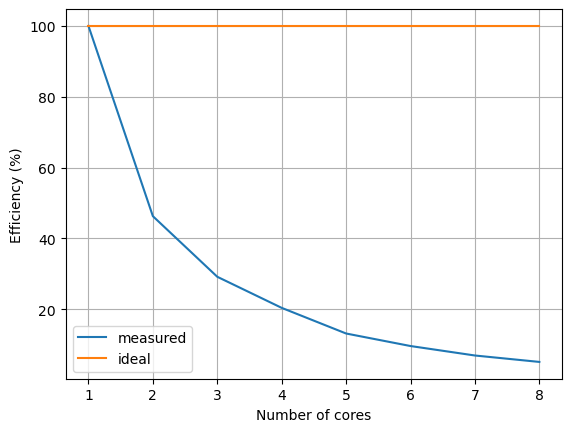

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import time

num_processes = 8
filename = 'weak_scaling.txt'

times = np.empty(num_processes)
partial_func = functools.partial(work,filename=filename)
for i in range(1,num_processes+1):
    print(i)
    max_counts = [1000]*i
    start_time = time.perf_counter()
    # primes = give_primes(start=start,end=start+i*work_per_process,num_processes=i)
    with Pool(processes=i) as p:
        _ = p.map(func=partial_func,iterable=max_counts)
    end_time = time.perf_counter()
    times[i-1] = end_time - start_time

fig,ax = plt.subplots()
ax.plot(np.arange(1,num_processes+1), 100*times[0]/times, label='measured')
ax.plot(np.arange(1,num_processes+1), 100*np.ones(num_processes), label='ideal')
ax.set_xlabel('Number of cores')
ax.set_ylabel('Efficiency (%)')
ax.legend()
ax.grid()

4. Last week we performed a weak scaling analysis for a pleasantly parallel problem. Now that we've added locks, is the weak scaling efficiency better or worse than for a pleasantly parallel problem?

**Hint:** it's easier to interpret weak scaling graphs if the y-axis (that is, the parallel efficiency) ranges from 0 to 1.

Weak scaling efficiency is significantly better pleasantly parallel problems. This is because in a sense, problems that are not pleasantly parallel are at least conceptually serial in part since there is a time dependence based on inter-process communication.

5. With the lock, the weak scaling efficiency drops dramatically as we increase the number of processes. Our code's runtime is increasing not only because we gave it more work, but because the processes are sharing that work less efficiently. Locks mean that each process gets exclusive access to a resource and all other processes must wait until that one is finished before accessing that same resource. Considering this, explain why increasing the number of processes degrades parallel performance.

As mentioned above, increasing the number of processes increases the number of users which are "requesting" the locked file/resources, which leads to increased interdependence of processes (a quasi-serial effect).

---
## Designing Away the Lock

Imagine a case where a set of processes is going to collectively generate some data and then save the results to a file. This is a very common parallel workflow for researchers, as we generally want the results of any calculations or analysis to be saved to file for later use.

For this example, we will have our processes construct a table of trigonometry functions in a CSV file:

In [18]:
import math

def save_trig(number, filename):

    sin = math.sin(number)
    cos = math.cos(number)
    tan = sin/cos
    sec = 1/cos
    csc = 1/sin
    cot = cos/sin

    with open(filename, "a") as f:
        # write the number and it's trigonometric results as a comma separated line
        f.write(f"{number},{sin},{cos},{tan},{sec},{csc},{cot}\n")

def write_trig_file(start, end, nprocs, filename):

    # overwrite file if exists already
    with open(filename, "w") as f:
        # write a header row
        f.write("n,sin,cos,tan,sec,csc,cot\n")

    partial_save_trig = functools.partial(save_trig, filename=filename)

    with multiprocessing.Pool(processes=nprocs) as p:
        p.map(partial_save_trig, range(start, end))

---
### Exercises

1. Run `write_trig_file` with `nprocs=1` as a test. Set `start=1` and `end=10000`. Pick a reasonable filename. Check that the table looks sensible using Pandas' `read_csv`.

In [21]:
import pandas as pd

nprocs = 1
start = 1
end = 10000
filename = 'serial_trig.csv'

write_trig_file(start=start,end=end,nprocs=nprocs,filename=filename)

df = pd.read_csv(filename)
print(df)

         n       sin       cos        tan        sec       csc       cot
0        1  0.841471  0.540302   1.557408   1.850816  1.188395  0.642093
1        2  0.909297 -0.416147  -2.185040  -2.402998  1.099750 -0.457658
2        3  0.141120 -0.989992  -0.142547  -1.010109  7.086167 -7.015253
3        4 -0.756802 -0.653644   1.157821  -1.529886 -1.321349  0.863691
4        5 -0.958924  0.283662  -3.380515   3.525320 -1.042835 -0.295813
...    ...       ...       ...        ...        ...       ...       ...
9994  9995 -0.999736  0.022971 -43.522453  43.533940 -1.000264 -0.022977
9995  9996 -0.520831  0.853660  -0.610115   1.171427 -1.920010 -1.639036
9996  9997  0.436924  0.899498   0.485742   1.111731  2.288727  2.058706
9997  9998  0.992973  0.118342   8.390701   8.450081  1.007077  0.119180
9998  9999  0.636087 -0.771617  -0.824355  -1.295979  1.572112 -1.213069

[9999 rows x 7 columns]


2. Currently, no lock is used when constructing the table in parallel. Run `write_trig_file` with 8 processes. How does the table change? What remains the same?

In [22]:
nprocs = 8
start = 1
end = 10000
filename = '8procs_trig.csv'

write_trig_file(start=start,end=end,nprocs=nprocs,filename=filename)

df = pd.read_csv(filename)
print(df)

         n       sin       cos        tan        sec       csc       cot
0        1  0.841471  0.540302   1.557408   1.850816  1.188395  0.642093
1      940 -0.616112 -0.787659   0.782206  -1.269585 -1.623082  1.278435
2        2  0.909297 -0.416147  -2.185040  -2.402998  1.099750 -0.457658
3     1879  0.321765  0.946820   0.339838   1.056167  3.107857  2.942580
4     1566  0.996479  0.083839  11.885589  11.927583  1.003533  0.084136
...    ...       ...       ...        ...        ...       ...       ...
9994  9995 -0.999736  0.022971 -43.522453  43.533940 -1.000264 -0.022977
9995  9996 -0.520831  0.853660  -0.610115   1.171427 -1.920010 -1.639036
9996  9997  0.436924  0.899498   0.485742   1.111731  2.288727  2.058706
9997  9998  0.992973  0.118342   8.390701   8.450081  1.007077  0.119180
9998  9999  0.636087 -0.771617  -0.824355  -1.295979  1.572112 -1.213069

[9999 rows x 7 columns]


The setup of the table remains entirely the same, and the data is correct, but the rows are not in order since the processes are not necessarily serialized in any specific order.

3. The total number of rows is likely unaffected, meaning all of our data is present. This isn't always guaranteed, as multiple processes writing to the same file at the same time may result in a loss of data. The uncertainty isn't worth the risk, so modify the code provided at the beginning of this section to include a lock.

In [23]:
@interprocess_locked('/tmp/tmp_lock')
def save_trig(number, filename):

    sin = math.sin(number)
    cos = math.cos(number)
    tan = sin/cos
    sec = 1/cos
    csc = 1/sin
    cot = cos/sin

    with open(filename, "a") as f:
        # write the number and it's trigonometric results as a comma separated line
        f.write(f"{number},{sin},{cos},{tan},{sec},{csc},{cot}\n")

def write_trig_file(start, end, nprocs, filename):

    # overwrite file if exists already
    with open(filename, "w") as f:
        # write a header row
        f.write("n,sin,cos,tan,sec,csc,cot\n")

    partial_save_trig = functools.partial(save_trig, filename=filename)

    with multiprocessing.Pool(processes=nprocs) as p:
        p.map(partial_save_trig, range(start, end))

4. Run `write_trig_file` again using the locked version. Now how does the table look? Are the rows sequential in `n` or are they shuffled? That is, does locking file access guarantee our results will come back in a particular order?

In [26]:
nprocs = 8
start = 1
end = 10000
filename = '8procs_locked_trig.csv'

write_trig_file(start=start,end=end,nprocs=nprocs,filename=filename)

df = pd.read_csv(filename)
print(df)

         n       sin       cos        tan        sec       csc       cot
0        1  0.841471  0.540302   1.557408   1.850816  1.188395  0.642093
1     1253  0.475444 -0.879746  -0.540433  -1.136692  2.103297 -1.850367
2     1254 -0.483397 -0.875401   0.552201  -1.142333 -2.068693  1.810936
3     1255 -0.997805 -0.066217  15.068803 -15.101948 -1.002200  0.066362
4     1256 -0.594836  0.803847  -0.739986   1.244018 -1.681136 -1.351376
...    ...       ...       ...        ...        ...       ...       ...
9994  8447  0.676239 -0.736682  -0.917952  -1.357438  1.478767 -1.089381
9995  8448 -0.254523 -0.967067   0.263191  -1.034055 -3.928917  3.799525
9996  8449 -0.951278 -0.308335   3.085213  -3.243230 -1.051217  0.324127
9997  8450 -0.773432  0.633879  -1.220158   1.577588 -1.292938 -0.819566
9998  8451  0.115503  0.993307   0.116282   1.006738  8.657749  8.599803

[9999 rows x 7 columns]


Even using the lock does not appear to guarantee the perfect order, as the rows `n` are not in perfect order on the whole, though they do appear in small chunks that are each arranged in numerical order.

5. As we saw in the last section, our parallel efficiency incurs a large penalty when we use a lock. We want to avoid this without sacrificing the reliability of our results. What's a way we can redesign our code to avoid using a lock? Essentially, our goal is to reframe this problem as a pleasantly parallel one where each process can work independently.

This would be pretty simple, since we know that all we desire is to return our `n` column in order. Thus, we could perform as pleasantly parallel, and simply perform some kind of sorting operation on the dataframe.

---
## For Next Class

For the next class, you'll need to understand a concept called "scope". Please utilize the following resources:

* This [video](https://www.youtube.com/watch?v=rddH26RhmUg) explaining namespaces
* This [video](https://www.youtube.com/watch?v=wueXfiVkw1I) introducing scope
* This [interactive lesson](https://www.w3schools.com/python/python_scope.asp) where you can play with the impact of scope